# FILTERING THE DATASET:

Along this script we will get from an initial list of products provided by our client, to a final list (as per the names and ids present within the real data), which will be used to filter our initial data in order to get a smaller, more manageable file.

This process will be divided in two main steps:

- Check the names in our list with the descriptions present in our data, analyze them and select a final list

- Use this list to filter our data and store the resulting information in a more small and convenient file

## CREATING THE LIST OF PRODUCTS FOR THE ANALYSIS:

After rearranging the data in a more convenient manner and doing some introductory analysis of the data, we now want to get down to work with our data.

A list has been given to us of the 10 products that our clients found as more relevant to their business.

What we want now is to check whether the names on the list correspond to certain uniques ids, or, as seen in the previous scripts, some conflict of unicity will arise between the id of our products and their descriptions.

So, we are going to check our dataframe and select from it the ids and descriptions of our products that match the indications given in our clients list. With the lists (in reality, two dictionaries) of the ids and descriptions that match every product given to us, we will decide which are the more appropriate.

Perhaps some guidance from our client would be needed at this stage.

### 1. Read dataframe

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math
import seaborn as sns


%matplotlib inline
pd.options.display.max_columns = None

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [219]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" # 'prueba.csv' 
exit_path = "../../data/02_intermediate/"

filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [13]:
# We create the list of products provided by the client
list_of_products=['croissant',
                  'croissant petit',
                  'tarta mousse 3 chocolates',
                  'tarta de manzana 2º',
                  'palmera de chocolate'
                  'tarta opera',
                  'postre fresas y mascarpone',
                  'milhojas frambuesa 2º',
                  'tortel',
                  'baguette']

In [224]:
# We import the dataframe:
df=pd.read_csv(file_path+file_name, sep=sep, nrows=100000)

In [225]:
df.sample(5)

,product_id,description,order_date,section,store,units_ordered
64053,118.0,BARRITAS DE PAN,26/8/2012 0:00:00,0,BmUP,"2,00"
61217,212.0,Empanadilla de espinacas,29/8/2018 0:00:00,0,BmUP,"0,00"
11912,9999.0,CAJA DE MINISANWICH DE 24 UND,2/7/2012 0:00:00,0,BmUP,"0,00"
32542,9999.0,SANWICH POLLO,23/7/2012 0:00:00,0,BmUP,"0,00"
46793,551.0,CAJA PALMERAS,9/4/2012 0:00:00,0,BmUP,"0,00"


### 2. Normalizing and aggregating description names

Unfortunately, there is no convention for the description and one id could 

1. Normalize descriptions as much as possible using:
    - Regex expressions 
    - Basic NLP for spell-checking.
2. Create a normalization file with the following structure:
    - Unique Product_id and normalized description
    - Flag to indicate if the product is part of the given list, or not.  
3. Finally review the list manually. 

### 2.1 Normalizing description names 

In [226]:
# Setting Null descriptions to 'no-description'
df['description'].fillna('no-description', inplace = True)

# Unique product descriptions
df_descriptions_unique = pd.Series(df['description'].unique())

# Most of the descriptions are in uppercase, however others are in lower:
df_descriptions_normalized = df_descriptions_unique.str.lower()

#replace non alfanumeric with space
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'[^0-9a-zA-Zº()ª:-]+', ' ') 

# We also notice that there are spacing issues at the begining, end of the description and between words:
df_descriptions_normalized=df_descriptions_normalized.str.strip()

# Remove multi-spacing. multi '-' and multi ':'
df_descriptions_normalized=df_descriptions_normalized.str.replace(r' +', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'-+', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r':+', ' ') 

In [227]:
pd.DataFrame(dict(desc_original = df_descriptions_unique, desc_normalized = df_descriptions_normalized)).sample(10)

,desc_original,desc_normalized
173,BOLSA DE PALITOS HOJADRE OREGANO,bolsa de palitos hojadre oregano
3060,EncargoTARTA SAN MARCOS DEL 3,encargotarta san marcos del 3
3362,Sandwich cangrejo,sandwich cangrejo
4125,"TARTA DE MANZANA 1º CON CARTEL, FELICIDADES AL...",tarta de manzana 1º con cartel felicidades alicia
3595,TACOS DE SALMON CON GAMBAS Y TRIGUEROS,tacos de salmon con gambas y trigueros
2706,"Tarta infantil rectangular del 1º con cartel ""...",tarta infantil rectangular del 1º con cartel f...
2184,EncargoTARTAMILHOJAYFRAMBUESA DEL 1,encargotartamilhojayframbuesa del 1
1125,B/250gr GAJOS,b 250gr gajos
1960,"EncargoSANDWHIS ROAST BEEF,ROQUEFORT,SALMON,VE...",encargosandwhis roast beef roquefort salmon ve...
3623,TARRO CRISTAL CEREZAS 450 GRS,tarro cristal cerezas 450 grs


Now lets gets get our hands dirty and apply some maths to calculate string distnace and finish cleaning all those messy product descriptions... This is what we are going to do:

1. Create a dataset with pastry products by parsing the bakery catalogues, and other pastry websites. (this was done manually, by converting the pdf catalogues to txt using an external web. THe resulting file is named productos.txt)

2. Following the indications from: https://medium.com/@hdezfloresmiguelangel/implementando-un-corrector-ortogr%C3%A1fico-en-python-utilizando-la-distancia-de-levenshtein-498ec0dd1105 create an spell-checker based on the products.txt dataset and the Levenshtein distance


In [228]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../../data/01_additional_data/productos.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [229]:
correction("trta")

'tarta'

In [230]:
correction("café")

'cafe'

Fantastic! the it seems to work. Lets now apply it to our dataset:

In [231]:
def spell_check (line):
    "Given a sentence, returns spell-checks word by word"
    if type(line) == str and len(line) > 0:
        new = []
        line = line.split(" ")
        for word in line:
            if type(word) == str:
                word = correction(word)
            new.append(word)
        return " ".join(new)
            
    else:
        return line

In [232]:
# CAUTION! The following cell e may take a long time to process (5 hours): 

# spell-check word by word the dataset:
df_descriptions_normalized = df_descriptions_normalized.apply(lambda line: spell_check(line))

Lets now merge the normalized names back to the original file, and check how effective was this cleaning:

In [233]:
to_merge = pd.DataFrame(dict(description = df_descriptions_unique, desc_normalized = df_descriptions_normalized))

df_with_normalized_descriptions_transactions = pd.merge(df, to_merge, how='left', on = 'description').sort_values(by='order_date')
df_with_normalized_descriptions_transactions.sample(5)

,product_id,description,order_date,section,store,units_ordered,desc_normalized
71396,6032.0,MINI PAU CHOCOLATE,16/7/2018 0:00:00,0,BmUP,"0,00",mini pan chocolate
43772,8730.0,MOLDE PAN NUEZ Y PASA,4/4/2012 0:00:00,0,BmUP,"2,00",cold pan que y para
11729,9999.0,EncargoCARTEL QUE PONGA CAFE,12/8/2014 0:00:00,0,BmUP,"1,00",encargocartel que olga cafe
85899,127.0,MAGDALENAS,14/2/2012 0:00:00,0,BmUP,"3,00",magdalenas
77324,452.0,MOUSSE 3 CHOCOLATES 1º,31/10/2014 0:00:00,0,BmUP,"2,00",mousse 3 chocolates 1


In [234]:
#Control merge size:
if (df.shape[0] == df_with_normalized_descriptions_transactions.shape[0] ): 
    test0 = "OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test0 = "ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' "
print(test0)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 


In [235]:
# Checking effectiveness of the data cleaning:
unique_descriptions_raw = len(df['description'].unique())
unique_descriptions_normalized = len(df_with_normalized_descriptions_transactions['desc_normalized'].unique())
print('The product descritions were cleaned from {} unique names to {}.'.format(unique_descriptions_raw,unique_descriptions_normalized))

The product descritions were cleaned from 4551 unique names to 4194.


Not super effective...

In [236]:
# Saving the file to the intermiady folder
output_path_df_with_normalized_descriptions_transactions = exit_path + 'data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions.to_csv(output_path_df_with_normalized_descriptions_transactions, index = False, sep = ';' )

### 2.2 Identifying product descriptions that the client wants us to predict

It is time to create the file that will be manually reviewed.

- First, we compare the normalized descriptions with the list of products provided with the client, and suggest matches using the library fuzzywuzzy
- Second, we will use the results from the other analysis.
- third, we will manually evaluate if the results are good

#### 2.2.1 Using the library fuzzywuzzy to compare the product normalized descriptions with the list of products provided by the client and suggest a match, or alternatively - "match-not-found"

In [237]:
df_normalized_desc_unique = pd.DataFrame(df_with_normalized_descriptions_transactions["desc_normalized"].unique(), columns = ['desc_normalized'])

In [238]:
def find_match (line, options = list_of_products):
    "Returns product match if the the calculated difference between strings is greater than 80, 'match-not-found' otherwise"
    if not(line is None) and type(line)== str:
        highest = process.extractOne(line,list_of_products)
        if not(highest is None) and highest[1] >80:
            return highest[0]
        else:
            return 'match-not-found'
    else:
        return 'match-not-found'

# Applying matching function to all product normalized descriptions
df_normalized_desc_unique["target_names_fuzzywuuzy"] = df_normalized_desc_unique["desc_normalized"].apply(lambda line: find_match(line))

Lets now evaluate how effectively did we match the normalized descriptions with the list that the client provided us:

In [239]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_desc_unique[df_normalized_desc_unique['desc_normalized'].str.contains('mousse')].head(10)

,desc_normalized,target_names_fuzzywuuzy
54,mousse 3 chocolates 1,tarta mousse 3 chocolates
55,mousse 3 chocolates 2,tarta mousse 3 chocolates
56,postres mousse tres chocolates,match-not-found
248,postres mousse de limon,match-not-found
370,mousse 3 chocolates 3 escrito sobre la tarta t...,tarta mousse 3 chocolates
390,mousse 3 chocolates 3,tarta mousse 3 chocolates
472,mousse chocolate blanco,match-not-found
484,postres mousse frutas bosque,match-not-found
575,mousse 3 chocolates 2 cartel felicidades rebeca,tarta mousse 3 chocolates
583,encargotarta mousse 3 chocolates segun,tarta mousse 3 chocolates


As we can see... its not actually very good, lets try something different.

#### 2.2.1 Using the results from the other analysis

Lets now use the results from the manual analysis to see how efective the measure was:

In [240]:
# Since this matching is performed at id level, 
# lets create a new dataset with unique product_id, descriptions, and evaluate it:
df_normalized_id_desc_unique = df_with_normalized_descriptions_transactions[["product_id",'desc_normalized']].drop_duplicates()

In [241]:
dict_of_products_matches={100: 'croissant', 
                  101: 'croissant',
                  102: 'croissant',
                  103: 'croissant petit',
                  9999: 'tarta mousse 3 chocolates', # almost only for order, creating a new id for this product is suggested
                  462: 'tarta de manzana 2º',
                  182: 'palmera de chocolate', # palmeras: 140
                  414: 'tarta opera', # 9999, for order, mostly. If included, creating a new id for this product is suggested
                  4511:'postre fresas y mascarpone',
                  459: 'milhojas frambuesa 2º',
                  112: 'tortel',
                  115: 'baguette'}

In [242]:
def target_names_a(product_id, dict_of_products_matches= dict_of_products_matches):
    'Returns match if the product_id is found within the given dict or, otherise "match-not-found"'
    if not(product_id is None) and not(math.isnan(product_id)) and int(product_id)  in dict_of_products_matches:
        return dict_of_products_matches[int(product_id)]
    else:
        return 'match-not-found'

df_normalized_id_desc_unique['target_names_manual_analysis']=df_normalized_id_desc_unique["product_id"].apply(lambda line: target_names_a(line))

Lets now check how effective this was:

In [243]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_id_desc_unique[df_normalized_id_desc_unique['desc_normalized'].str.contains('mousse')].head(15)

,product_id,desc_normalized,target_names_manual_analysis
49086,452.0,mousse 3 chocolates 1,match-not-found
49085,451.0,mousse 3 chocolates 2,match-not-found
49072,450.0,postres mousse tres chocolates,match-not-found
68303,821.0,postres mousse de limon,match-not-found
58230,45.0,postres mousse tres chocolates,match-not-found
73861,453.0,mousse 3 chocolates 3 escrito sobre la tarta t...,match-not-found
78650,453.0,mousse 3 chocolates 3,match-not-found
8058,618.0,mousse chocolate blanco,match-not-found
7050,879.0,postres mousse frutas bosque,match-not-found
78697,451.0,mousse 3 chocolates 2 cartel felicidades rebeca,match-not-found


Again, not very good, since most of the 'mousse 3 chocolates' are unmatched.

It is clear that we need an better way to match the results. Lets try doing keywords filtering product by product.

In [244]:
# TO DELETE!
output_path_df_with_normalized_descriptions_transactions = exit_path + 'data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions = pd.read_csv(output_path_df_with_normalized_descriptions_transactions, sep = ';' )


### 2.3 Review Product by Product

In [245]:
#First, lets create again a dataframe with unique descriptions
unique_normalized_decriptions = df_with_normalized_descriptions_transactions[['product_id','desc_normalized']].drop_duplicates()

#And a empty list to add all the unitary analysis. It will be use to concatenate results.
list_of_dfs = []

In [246]:
# Functions that we will use:

def plot_count_per_id(df):
    transactions_by_id = df.groupby("product_id")['desc_normalized'].count()
    transactions_by_id.plot.bar()

#### 2.3.1 Matching: milhojas de frambuesa 2º

In [247]:
def filter_milhojas (df):
    'Filters the product descriptions of given dataset by "milhojas" and "frambuesa 2"'
    milhojas = df[df['desc_normalized'].str.contains('milhojas')]
    milhojas_frambuesa = milhojas[milhojas['desc_normalized'].str.contains('frambuesa 2')].copy()
    return milhojas_frambuesa


In [248]:
# Filter the transactions dataset
milhojas_frambuesa_transacciones=filter_milhojas(df_with_normalized_descriptions_transactions)
milhojas_frambuesa_transacciones.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
52,459.0,MILHOJAS FRAMBUESA 2º,1/10/2013 0:00:00,0,BmUP,"1,00",milhojas frambuesa 2
311,459.0,MILHOJAS FRAMBUESA 2º,1/10/2013 0:00:00,0,BmUP,"0,00",milhojas frambuesa 2
385,459.0,MILHOJAS FRAMBUESA 2º,1/10/2018 0:00:00,0,BmUP,"1,00",milhojas frambuesa 2
481,459.0,MILHOJAS FRAMBUESA 2º,1/11/2013 0:00:00,0,BmUP,"2,00",milhojas frambuesa 2
610,459.0,MILHOJAS FRAMBUESA 2º,1/11/2014 0:00:00,0,BmUP,"0,00",milhojas frambuesa 2


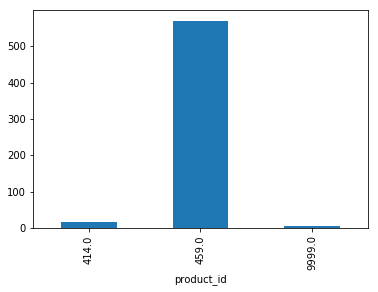

In [249]:
# Plot the ditribution of 'product_id'
plot_count_per_id(milhojas_frambuesa_transacciones)

Lets explore the names distribution of 414, 459 and 9999:

In [250]:
#Names distribution for product_id = 459:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==459.0]['desc_normalized'].value_counts().head()

milhojas frambuesa 2                                    550
milhojas fresa 2                                          3
milhojas frambuesa 2 y la con crema en las dos capas      1
milhojas fresas 2                                         1
milhojas frambuesa 2 con cartel felicidades gabriel       1
Name: desc_normalized, dtype: int64

In [251]:
#Names distribution for product_id = 414:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==414.0]['desc_normalized'].value_counts().head()

tarta milhojas frambuesa 2     11
tarta tres chocolates 2         8
tarta milhojas 2                4
tarta mus tres chocolates 2     3
tarta opera 2                   3
Name: desc_normalized, dtype: int64

In [252]:
#Names distribution for product_id = 9999:
df_with_normalized_descriptions_transactions[(df_with_normalized_descriptions_transactions['product_id']==9999.0) & (df_with_normalized_descriptions_transactions['desc_normalized'].str.contains('milhoja'))]['desc_normalized'].value_counts().head()

encargo tarta milhojas del 1                6
encargo tarta milhojas y frambuesa del 1    4
postres milhojas de frambuesa               4
encargotarta milhojas de frambuesa del 3    4
tarta milhojas de frambuesa del 3           3
Name: desc_normalized, dtype: int64

It seems there is a strong correlation with id 459, however 459 it also includes other types of 'milhojas'. In addition, 'milhojas de frambuesa 2º' is also included in id number 414, which seems to be a multiple 'tartas' id, and id 9999, which is the id used for custom orders.

For these reasons, we decide to filter milhojas based on the description (filtering the dataframe with only disting 'product_id' and 'des_normalized' values:

In [253]:
#Save unique product_id and product_description:
milhojas_frambuesa = filter_milhojas(unique_normalized_decriptions)
milhojas_frambuesa['target_names_prod_by_prod'] = 'milhojas frambuesa'
list_of_dfs.append(milhojas_frambuesa)
milhojas_frambuesa.sample(4)

,product_id,desc_normalized,target_names_prod_by_prod
11801,459.0,milhojas frambuesa 2 y cartel felicidades,milhojas frambuesa
80201,459.0,milhojas frambuesa 2 felix cumplea on alejandro,milhojas frambuesa
6892,459.0,milhojas frambuesa 2 felix cumplea on alejandr...,milhojas frambuesa
27606,459.0,milhojas frambuesa 2 con cartel felix cumplea ...,milhojas frambuesa


#### 2.3.2 Matching: croissant petite

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant petite' had an strong correlation with id number '103' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [254]:
def filter_croissant_petit (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_petite = croissant[croissant['desc_normalized'].str.contains('petit')].copy()
    return croissant_petite

In [255]:
# Plotting the results:
transactions_croissant_petite = filter_croissant_petit(df_with_normalized_descriptions_transactions)
transactions_croissant_petite.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
238,103.0,CROISSANT PETIT,1/10/2013 0:00:00,0,BmUP,"4,00",croissant petit
544,103.0,CROISSANT PETIT,1/11/2013 0:00:00,0,BmUP,"0,00",croissant petit
624,103.0,CROISSANT PETIT,1/11/2014 0:00:00,0,BmUP,"0,00",croissant petit
628,103.0,CROISSANT PETIT,1/11/2014 0:00:00,0,BmUP,"2,00",croissant petit
821,103.0,CROISSANT PETIT,1/12/2012 0:00:00,0,BmUP,"7,00",croissant petit


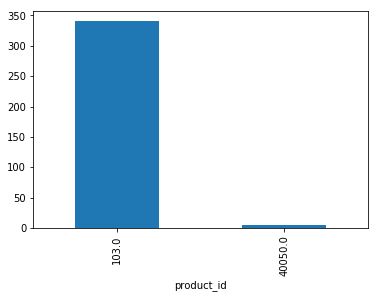

In [256]:
plot_count_per_id(transactions_croissant_petite)

It is clear that id '103' represents the 'croissant petite';  in fact, after reviweing the data with the client, he suggested only taking 103.

In [257]:
# Saving id=103 as croissant petit
croissant_petit = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==103.0].copy()
croissant_petit['target_names_prod_by_prod'] = 'croissant petit'
list_of_dfs.append(croissant_petit)
croissant_petit.head()

,product_id,desc_normalized,target_names_prod_by_prod
238,103.0,croissant petit,croissant petit
69694,103.0,croissant petit alargados piezas y futbol,croissant petit
79882,103.0,croissant petit y y futbol y y,croissant petit


#### 2.3.3 Matching: croissant

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant simple' had an strong correlation with id number '100' and '101' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [258]:
def filter_croissant_simple (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_simple = croissant[~croissant['desc_normalized'].str.contains('petit|tira|masa')].copy()
    return croissant_simple

In [259]:
transactions_croissant_simple = filter_croissant_simple(df_with_normalized_descriptions_transactions)
transactions_croissant_simple.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
163,215.0,CROISANNT SOBRASADA PQ COCIDOS,1/10/2013 0:00:00,0,BmUP,"1,00",croissant sobrasada px cocido
176,5001.0,CROISSANT ALARGADO GRANDE PIEZAS,1/10/2013 0:00:00,0,BmUP,"0,00",croissant alargado grande piezas
183,132.0,CROISSANT INTEGRAL,1/10/2013 0:00:00,0,BmUP,"2,00",croissant integral
221,100.0,CROISANTS,1/10/2013 0:00:00,0,BmUP,"18,00",croissant
236,106.0,CROISANTS VACIOS,1/10/2013 0:00:00,0,BmUP,"11,00",croissant racion


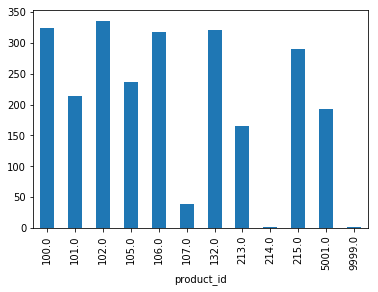

In [260]:
plot_count_per_id(transactions_croissant_simple)

Interesting, the correlation seems to exsit for several ids... Lets explore a bit more... Lets plot the most common description from each id and see if we find any pattern:

In [261]:
for i in transactions_croissant_simple['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 215.0 
-
croissant sobrasada px cocido    291
Name: desc_normalized, dtype: int64

***Plotting id: 5001.0 
-
croissant alargado grande piezas    191
hamburguesitas                        4
mini hamburguesitas                   3
pan de centeno                        3
mini pizzas                           3
Name: desc_normalized, dtype: int64

***Plotting id: 132.0 
-
croissant integral    321
Name: desc_normalized, dtype: int64

***Plotting id: 100.0 
-
croissant                                                            323
croissant en estos 7 estar incluidos los 2 que pedidos con el pan      1
croissant urgente manda con el coche del pan                           1
Name: desc_normalized, dtype: int64

***Plotting id: 106.0 
-
croissant racion                                      317
croissant racion 2 las cocido y 2 cruda con el pan      1
Name: desc_normalized, dtype: int64

***Plotting id: 105.0 
-
croissant chocolate       227
croissant de chocolate     10
Name: 

It seems that they have different types of croissant. Checking with the client, he suggested taking only: 100.0 and 101.0 that contains the word 'croissant'

In [262]:
croissant_simple = unique_normalized_decriptions[(unique_normalized_decriptions['product_id']==100.0)|(unique_normalized_decriptions['product_id']==101.0)].copy()
croissant_simple = croissant_simple[croissant_simple['desc_normalized'].str.contains('croissant')]
croissant_simple = croissant_simple[~croissant_simple['desc_normalized'].str.contains('petit|tira|masa')].copy()

croissant_simple['target_names_prod_by_prod'] = 'croissant simple'
list_of_dfs.append(croissant_simple)
croissant_simple.head()

,product_id,desc_normalized,target_names_prod_by_prod
221,100.0,croissant,croissant simple
240,101.0,croissant,croissant simple
28977,100.0,croissant en estos 7 estar incluidos los 2 que...,croissant simple
58738,100.0,croissant urgente manda con el coche del pan,croissant simple
63487,101.0,croissant integral las,croissant simple


#### 2.3.4 Matching: tarta mousse tres chocolates

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'mousse tres chocolates' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [263]:
def filter_mousse_tres_chocolates (df):
    tarta = df[df['desc_normalized'].str.contains('tarta')].copy()
    mousse = tarta[tarta['desc_normalized'].str.contains('mousse|mus')].copy()
    mousse_tres = mousse[mousse['desc_normalized'].str.contains('tres|3')].copy()
    mousse_tres = mousse_tres[~mousse_tres['desc_normalized'].str.contains('mini')].copy()
    mousse_tres_chocolates = mousse_tres[mousse_tres['desc_normalized'].str.contains('chocolate')].copy()
    return mousse_tres_chocolates

In [264]:
transactions_mousse_tres_chocolates = filter_mousse_tres_chocolates(df_with_normalized_descriptions_transactions)
transactions_mousse_tres_chocolates.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
444,453.0,MOUSSE 3 CHOCOLATES 3º Escrito sobre la tarta...,1/10/2018 0:00:00,0,BmUP,"0,00",mousse 3 chocolates 3 escrito sobre la tarta t...
1102,9999.0,EncargoTARTA MOUSSE 3 CHOCOLATES SEGUNDO,1/12/2013 0:00:00,0,BmUP,"0,00",encargotarta mousse 3 chocolates segun
2873,9999.0,Encargo TARTA MANZANA DEL 3 CON UNA PLACA DE C...,1/7/2011 0:00:00,0,BmUP,"0,00",encargo tarta manzana del 3 con una para de ch...
3564,9999.0,Encargo TARTA MOUSS TRES CHOCOLATES DEL 3 ESCR...,1/8/2013 0:00:00,0,BmUP,"0,00",encargo tarta mousse tres chocolates del 3 esc...
4015,9999.0,TARTA MOUSSE DE TRES CHOLOLATES DEL 6º PINTADO...,1/9/2012 0:00:00,0,BmUP,"0,00",tarta mousse de tres chocolates del 6 pintado ...


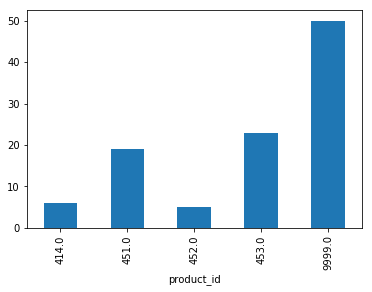

In [265]:
plot_count_per_id(transactions_mousse_tres_chocolates)

Lets explore it more by having a look at the full distribution of names:

In [266]:
for i in transactions_mousse_tres_chocolates['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 453.0 
-
mousse 3 chocolates 3                                                           366
mousse 3 chocolates 4                                                             2
mousse 3 chocolates 3 escrito en la tarta felicidades jimena                      1
mousse 3 chocolates 4 con dibujo sobre comino de chocolate y manda a roberto      1
mousse 3 chocolates 4 y escrito en la tarta felicidades marta en y decorada       1
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo               107
sandwich cangrejo      42
sandwich vegetal       42
sandwich salmon        41
sandwich roquefort     40
Name: desc_normalized, dtype: int64

***Plotting id: 452.0 
-
mousse 3 chocolates 1                                          405
mousse 3 chocolates 1 felicidades pato y pavo                    1
mousse 3 chocolates 1 escrito felix cumplea on juan              1
mousse 3 chocolates 1 con un cartel felix cumplea on arturo      1
mousse 3 chocolates 1 feo cumple

It seems that 'tarta mousse tres chocolates' is all over the place... So the easiest is to filter by product description"

In [267]:
mousse_tres_chocolates = filter_mousse_tres_chocolates(unique_normalized_decriptions)
mousse_tres_chocolates['target_names_prod_by_prod'] = 'mousse tres chocolates'
list_of_dfs.append(mousse_tres_chocolates)
mousse_tres_chocolates.head()

,product_id,desc_normalized,target_names_prod_by_prod
444,453.0,mousse 3 chocolates 3 escrito sobre la tarta t...,mousse tres chocolates
1102,9999.0,encargotarta mousse 3 chocolates segun,mousse tres chocolates
2873,9999.0,encargo tarta manzana del 3 con una para de ch...,mousse tres chocolates
3564,9999.0,encargo tarta mousse tres chocolates del 3 esc...,mousse tres chocolates
4015,9999.0,tarta mousse de tres chocolates del 6 pintado ...,mousse tres chocolates


#### 2.3.5 Matching: tarta de manzana 2
From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'tarta de manzana 2' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [268]:
def filter_tarta_manzana_2 (df):
    manzana_tarta = df[df['desc_normalized'].str.contains('manzana')]
    #manzana_tarta = manzana[manzana['desc_normalized'].str.contains('tarta')].copy() #Removed because we saw it had better fit
    manzana_tarta = manzana_tarta[~manzana_tarta['desc_normalized'].str.contains('caramelo')].copy()
    manzana_tarta_dos = manzana_tarta[manzana_tarta['desc_normalized'].str.contains('dos|2')].copy()

    return manzana_tarta_dos

In [269]:
transactions_manzana_tarta_dos=filter_tarta_manzana_2(df_with_normalized_descriptions_transactions)

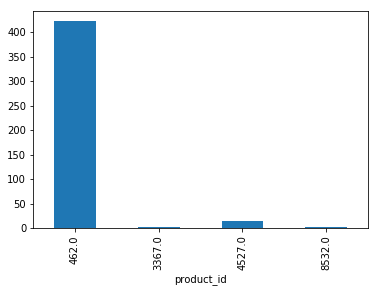

In [270]:
plot_count_per_id(transactions_manzana_tarta_dos)

Looks like we found a winner!

In [271]:
manzana_tarta_dos = filter_tarta_manzana_2(unique_normalized_decriptions)
manzana_tarta_dos['target_names_prod_by_prod'] = 'tarta de manzana'
list_of_dfs.append(manzana_tarta_dos)
manzana_tarta_dos.head()

,product_id,desc_normalized,target_names_prod_by_prod
50,462.0,manzana 2,tarta de manzana
2181,3367.0,pavo asado con ados de manzana caramelizados,tarta de manzana
3755,462.0,tarta de manzana 2,tarta de manzana
4710,4527.0,tarta choco leche y manzana y valentin 2,tarta de manzana
21257,462.0,manzana 2 con cartel que olga y felix cumplea ...,tarta de manzana


#### 2.3.6 Matching: palmera de chocolate 

In [272]:
def filter_palmera_chocolate (df):
    palmera = df[df['desc_normalized'].str.contains('palmera')]
    palmera_chocolate = palmera[palmera['desc_normalized'].str.contains('chocolate|trufa')].copy() #Added trufa after reviwing results
    return palmera_chocolate

In [273]:
transactions_palmera_chocolate = filter_palmera_chocolate(df_with_normalized_descriptions_transactions)
transactions_palmera_chocolate.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
355,182.0,PALMERAS DE TRUFA,1/10/2018 0:00:00,0,BmUP,"2,00",palmera de trufa
1029,182.0,PALMERAS DE TRUFA,1/12/2012 0:00:00,0,BmUP,"4,00",palmera de trufa
1248,182.0,PALMERAS DE TRUFA,1/2/2012 0:00:00,0,BmUP,"0,00",palmera de trufa
1385,182.0,PALMERAS DE TRUFA,1/3/2012 0:00:00,0,BmUP,"3,00",palmera de trufa
1481,182.0,PALMERAS DE TRUFA,1/3/2019 0:00:00,0,BmUP,"0,00",palmera de trufa


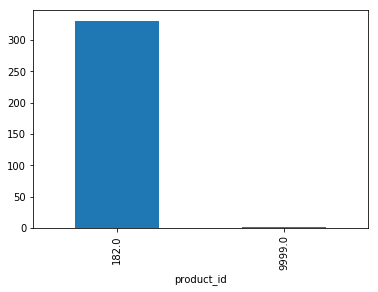

In [274]:
plot_count_per_id(transactions_palmera_chocolate)

Again, we have a winner!

In [275]:
palmera_chocolate = filter_palmera_chocolate(unique_normalized_decriptions)
palmera_chocolate['target_names_prod_by_prod'] = 'palmera chocolate'

list_of_dfs.append(palmera_chocolate)
palmera_chocolate.head()

,product_id,desc_normalized,target_names_prod_by_prod
355,182.0,palmera de trufa,palmera chocolate
68786,9999.0,palmera de chocolate unidades,palmera chocolate


#### 2.3.7 Matching: tarta ópera 

In [276]:
def filter_tarta_opera(df):
    opera = df[df['desc_normalized'].str.contains('opera')]
    opera_tarta = opera[opera['desc_normalized'].str.contains('tarta')].copy()
    return opera_tarta

In [277]:
transactions_tarta_opera = filter_tarta_opera(df_with_normalized_descriptions_transactions)

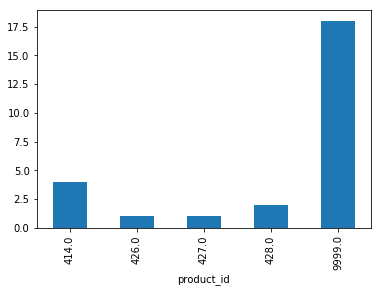

In [278]:
plot_count_per_id(transactions_tarta_opera)

In [279]:
for i in transactions_tarta_opera['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 9999.0 
-
encargo               107
sandwich cangrejo      42
sandwich vegetal       42
sandwich salmon        41
sandwich roquefort     40
Name: desc_normalized, dtype: int64

***Plotting id: 414.0 
-
tarta milhojas frambuesa 2     11
tarta tres chocolates 2         8
tarta milhojas 2                4
tarta mus tres chocolates 2     3
tarta opera 2                   3
Name: desc_normalized, dtype: int64

***Plotting id: 428.0 
-
opera 2                                                376
opera 2 con cartel de felix cumplea on paula             1
opera 2 con cartel felix cumplea on jerez                1
opera 2 escrito en la tarta felicidades cuchifritin      1
opera 3 y felix cumplea on anastasia                     1
Name: desc_normalized, dtype: int64

***Plotting id: 426.0 
-
opera 4                                                                              6
opera 4 i fino de ado i principio de ada y la con tu pan tacos 18 felicidades ana    1
opera 4 escrito en 

Again, all over the place, so we decided to use the description filter:

In [280]:
tarta_opera = filter_tarta_opera(unique_normalized_decriptions)
tarta_opera['target_names_prod_by_prod'] = 'tarta opera'

list_of_dfs.append(tarta_opera)
tarta_opera.head()

,product_id,desc_normalized,target_names_prod_by_prod
816,9999.0,encargo tarta opera del 5,tarta opera
834,9999.0,encargo tarta opera del 8,tarta opera
2452,9999.0,tarta opera del 2 escrito sobre la tarta felic...,tarta opera
8371,9999.0,tarta opera del 4 con cartel escrito y hugo y ...,tarta opera
11075,9999.0,encargotarta opera del 3 escribir sobre la tar...,tarta opera


#### 2.3.9 Matching: postre de fresas y mascarpone

In [281]:
def filter_postre_fresas_mascarpone (df):
    postre = df[df['desc_normalized'].str.contains('postre')]
    postre_fresa = postre[postre['desc_normalized'].str.contains('fresa')].copy()
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('eclair')].copy() #Client indication
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('tartaleta')].copy() #Client indication

    postre_fresa_mascarpone = postre_fresa[postre_fresa['desc_normalized'].str.contains('mascarpone')].copy()
    return postre_fresa_mascarpone

In [282]:
transactions_postre_fresas_mascarpone = filter_postre_fresas_mascarpone(df_with_normalized_descriptions_transactions)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


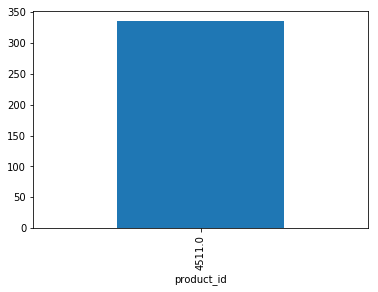

In [283]:
plot_count_per_id(transactions_postre_fresas_mascarpone)

In [284]:
for i in transactions_postre_fresas_mascarpone['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 4511.0 
-
postres fresas y mascarpone    336
Name: desc_normalized, dtype: int64



Seems that the filter is working :)

In [285]:
postre_fresas_mascarpone = filter_postre_fresas_mascarpone(unique_normalized_decriptions)

postre_fresas_mascarpone['target_names_prod_by_prod'] = 'postre de fresas y mascarpone'
list_of_dfs.append(postre_fresas_mascarpone)
postre_fresas_mascarpone.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,product_id,desc_normalized,target_names_prod_by_prod
326,4511.0,postres fresas y mascarpone,postre de fresas y mascarpone


#### 2.3.9 Matching: tortel

In [286]:
def filter_tortel (df):
    tortel = df[df['desc_normalized'].str.contains('tortel')].copy()
    tortel = tortel[~tortel['desc_normalized'].str.contains('tortellini|mini')].copy()

    return tortel

In [287]:
transactions_tortel = filter_tortel(df_with_normalized_descriptions_transactions)

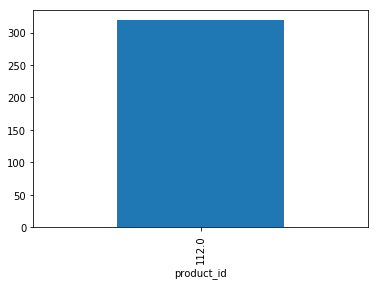

In [288]:
plot_count_per_id(transactions_tortel)

In [289]:
for i in transactions_tortel['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 112.0 
-
torteles                                                            318
torteles en estos 9 estar incluidos los 3 que pedidos con el pan      1
torteles mini piezas cruda                                            1
Name: desc_normalized, dtype: int64



In [290]:
tortel = filter_tortel(unique_normalized_decriptions)

tortel['target_names_prod_by_prod'] = 'tortel'
list_of_dfs.append(tortel)
tortel.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
206,112.0,torteles,tortel
28978,112.0,torteles en estos 9 estar incluidos los 3 que ...,tortel


#### 2.3.10 Matching: baguette

In [291]:
def filter_baguette (df):
    baguette = df[df['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()
    return baguette

In [292]:
transaction_baguette = filter_baguette(df_with_normalized_descriptions_transactions)

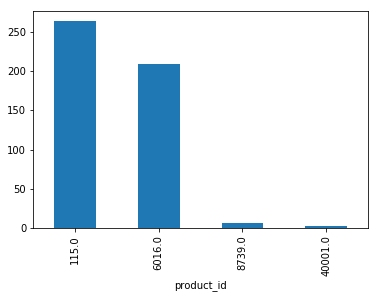

In [293]:
plot_count_per_id(transaction_baguette)

In [294]:
for i in transaction_baguette['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 115.0 
-
baguette mallorca    254
baguett mallorca      10
Name: desc_normalized, dtype: int64

***Plotting id: 6016.0 
-
baguet piezas 5 hora    209
Name: desc_normalized, dtype: int64

***Plotting id: 8739.0 
-
baguette mallorca integral    7
Name: desc_normalized, dtype: int64

***Plotting id: 40001.0 
-
baguet    2
Name: desc_normalized, dtype: int64



Per client indications we take id = 115.0 containing baguette

In [295]:
baguette = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==115.0].copy()
baguette = baguette[baguette['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()

baguette['target_names_prod_by_prod'] = 'baguette'
list_of_dfs.append(baguette)
baguette.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
210,115.0,baguette mallorca,baguette
2860,115.0,baguett mallorca,baguette


### Lets now concatenate results, merge them back to the  full list of normalized descriptions and evaluate its effectiveness

In [296]:
# Lets concatenate the results:
list_of_products_df = pd.concat(list_of_dfs, sort=False)

In [297]:
df_desc_normalezed_vs_prod_by_prod = pd.merge(df_with_normalized_descriptions_transactions, list_of_products_df,how='left',on=['desc_normalized','product_id'])

## Merging test:

In [298]:
#Control merge size:
if (df_with_normalized_descriptions_transactions.shape[0] == df_desc_normalezed_vs_prod_by_prod.shape[0] ): 
    test1 = "OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test1 = "ERROR - 'df' has NOT the same size as 'df_desc_normalezed_vs_prod_by_prod' "

print(test1)

OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 


*NOTE:*

During the first executions of code with the full transactions file, this error was failing; 'df' had less rows than 'df_with_normalized_descriptions_transactions'. The reason for this was not easy to identify, however digging we found that that in the normalized description two products descriptions ware naming two different products in the description, however this was not the case for the raw description (before the spell-cheacker):

for example:
- Normalized prod description: 'tarta mousse 3 chocolates de 20 raciones con escrito sobre la tarta manzana y mini felicidades'
- Raw description: 'TARTA MOUSSE 3 CHOCOLATES DE 20 RACIONES CON ESCRITO SOBRE LA TARTA:  MARIANA Y DANI FELICIDADES'

Basically, the spell-corrector was solving some problems; normalizing 'trata' , 'taaarta' under 'tarta', but adding a new one: normalizing words that it doesnt know, that may be a correct word, to a word that it knows: 'MARIANA' to 'manzana'... Ofcourse this is a weakness, however from the manual inspections that were performed, it doesnt seem to happen often.

How we solve it by adding to the bakery products dataset: 
- A list of the most common male and female spanish names: in order to avoid confusion in the names

sources of the datasets:
- spanish names:https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177009&menu=resultados&secc=1254736195454&idp=1254734710990


Also, in this case we added some names that we found to the excel; the right thing to do should we had more time, would be to polish the dataset, by adding not just mallorca catalogue and names, but also a book in spanish. Perhaps, it would also be interesting to applying NLP to identify NAMES from the product descriptions and add them to the products dataset...

### 2.5 Test that data has not been corrputed

To test the integrity of the data, the original dataset should be the same as the last dataset without that we added, in other words, without the columns with the normalized descriptuons, and the target names:

In [299]:
# First, lets check the size of both dataframes:
print("Original dataset shape: {}".format(df.shape))
print("Resulting dataset shape: {}".format(df_desc_normalezed_vs_prod_by_prod.shape))

Original dataset shape: (100000, 6)
Resulting dataset shape: (100000, 8)


The shape looks good, we were expecting the resulting dataset to have to columns more. Lets now evauate if they are actually the same dataset if we remove the added columns:

In [300]:
# Selecting original columnsd from the resulting df
df_result = df_desc_normalezed_vs_prod_by_prod.loc[:, df.columns]

In [301]:
# Now, lets compare it with the original dataset, sorting them out in the same way:
df_result_sorted = df_result.sort_values(by = ['order_date','store','description','product_id', 'units_ordered']).reset_index().drop('index', axis = 1)
df_original_sorted = df.sort_values(by = ['order_date','store','description',  'product_id', 'units_ordered']).reset_index().drop('index', axis = 1)

In [302]:
df_result_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,172.0,1/2 PAN DE MOLDE ENVUELTO,1/10/2013 0:00:00,0,BmUP,"0,00"
1,615.0,ALASKAS FRAMBUESA,1/10/2013 0:00:00,0,BmUP,"1,00"
2,3341.0,ALCACHOFAS CON JAMÓN,1/10/2013 0:00:00,0,BmUP,"0,00"
3,7001.0,ALMENDRA BASTON CARAMELIZADA BOTE 120 GRS,1/10/2013 0:00:00,0,BmUP,"4,00"
4,7004.0,ALMENDRA FILETEADA BOTE 75 GRS,1/10/2013 0:00:00,0,BmUP,"0,00"


In [303]:
df_original_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,172.0,1/2 PAN DE MOLDE ENVUELTO,1/10/2013 0:00:00,0,BmUP,"0,00"
1,615.0,ALASKAS FRAMBUESA,1/10/2013 0:00:00,0,BmUP,"1,00"
2,3341.0,ALCACHOFAS CON JAMÓN,1/10/2013 0:00:00,0,BmUP,"0,00"
3,7001.0,ALMENDRA BASTON CARAMELIZADA BOTE 120 GRS,1/10/2013 0:00:00,0,BmUP,"4,00"
4,7004.0,ALMENDRA FILETEADA BOTE 75 GRS,1/10/2013 0:00:00,0,BmUP,"0,00"


In [304]:
# Now that they have the same columns, and are sorted using the same criteria, lets evaluate if they are the same:
comparison_result = df_result_sorted.equals(df_original_sorted)

if comparison_result == True:
    test2 = 'OK - Original dataset is similar to the resulting dataset'
else:
     test2 ='ERROR - Original dataset NOT found'

print(test2)

OK - Original dataset is similar to the resulting dataset


### 2.6 Filter dataset to only include the products from the list provided by the client, and save to csv

In [310]:
df_target_products = df_desc_normalezed_vs_prod_by_prod[~df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]
# df_other_products = df_desc_normalezed_vs_prod_by_prod[df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]

In [311]:
df_target_products.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
50,462.0,MANZANA 2º,1/10/2013 0:00:00,0,BmUP,"1,00",manzana 2,tarta de manzana
52,459.0,MILHOJAS FRAMBUESA 2º,1/10/2013 0:00:00,0,BmUP,"1,00",milhojas frambuesa 2,milhojas frambuesa
206,112.0,TORTELES,1/10/2013 0:00:00,0,BmUP,"15,00",torteles,tortel
210,115.0,BAGUETTE MALLORCA,1/10/2013 0:00:00,0,BmUP,"7,00",baguette mallorca,baguette
211,112.0,TORTELES,1/10/2013 0:00:00,0,BmUP,"0,00",torteles,tortel


In [312]:
from datetime import datetime as dttm

df_target_products['date']=df_target_products['order_date'].apply(lambda x: dttm.strptime(x,'%d/%m/%Y 0:00:00')).copy()

df_target_products['units_ordered_numeric']=df_target_products['units_ordered'].str.split(",").str[0].astype(dtype='long').copy()

df_target_products.drop('order_date', axis=1, inplace=True)

df_target_products.drop('units_ordered', axis=1, inplace=True)

df_target_products.rename(columns={'units_ordered_numeric':'units_ordered'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [314]:
df_target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 
df_target_products.to_csv(df_target_products_file_name, index = False, sep = ';' )
# df_target_products.head()

In [315]:
unfiltered_products_file_name = exit_path + 'unfiltered_transactions.csv' 
df_other_products.to_csv(unfiltered_products_file_name, index = False, sep = ';' )
df_other_products.head()

,Unnamed: 0,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
0,5905,203.0,QUICHES DE QUESO,1/10/2013 0:00:00,0,BmUP,"12,00",quieres de queso,NaN
1,5890,144.0,HERRADURAS,1/10/2013 0:00:00,0,BmUP,"0,00",herraduras,NaN
2,5891,157.0,PALMERITAS CHOCOLATE CAJA 275 GRS,1/10/2013 0:00:00,0,BmUP,"6,00",palmeritas chocolate caja 25 gas,NaN
3,5892,158.0,PALMERITAS DE CHOCOLATE BOLSA 125 GRS,1/10/2013 0:00:00,0,BmUP,"6,00",palmeritas de chocolate bolsa 125 gas,NaN
4,5893,165.0,CAKE DE ZANAHORIA,1/10/2013 0:00:00,0,BmUP,"4,00",cafe de zanahoria,NaN


# ERROR CONTROL

In [316]:
print(test0)
print(test1)
print(test2)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - Original dataset is similar to the resulting dataset


FALTARIA LIMPIAR EL DATASET